In [75]:
!wget https://liveproject-resources.s3.amazonaws.com/other/MelanomaDetection.zip

--2020-08-08 22:28:08--  https://liveproject-resources.s3.amazonaws.com/other/MelanomaDetection.zip
Resolving liveproject-resources.s3.amazonaws.com (liveproject-resources.s3.amazonaws.com)... 52.216.27.180
Connecting to liveproject-resources.s3.amazonaws.com (liveproject-resources.s3.amazonaws.com)|52.216.27.180|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6296754 (6.0M) [application/zip]
Saving to: ‘MelanomaDetection.zip.1’

MelanomaDetection.z 100%[===================>]   6.00M  4.08MB/s    in 1.5s    

2020-08-08 22:28:10 (4.08 MB/s) - ‘MelanomaDetection.zip.1’ saved [6296754/6296754]



In [76]:
import os
os.makedirs('dataset',exist_ok=True)
!unzip MelanomaDetection.zip -d dataset


Archive:  MelanomaDetection.zip
replace dataset/MelanomaDetection/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [78]:
from glob import glob

train_list = glob('dataset/MelanomaDetection/labeled/*')
test_list = glob('dataset/MelanomaDetection/test/*')
unlabelled_list = glob('dataset/MelanomaDetection/unlabeled//*')

In [79]:
train_labels = [os.path.basename(os.path.join(i)).split('.')[0].split('_')[1] for i in train_list]
os.path.commonprefix(train_list)


'dataset/MelanomaDetection/labeled/'

In [171]:
import cv2
import numpy as np
import torch
from torch.utils.data.dataset import Dataset
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

class MelanomaDataset(Dataset):
# dir_path, transform=None
    def __init__(self, 
                 file_names: list, 
                 train: bool = True,
                 transforms = None):
      
        super().__init__()

        self.image_ids = file_names
        self.image_dir = os.path.commonprefix(file_names)
        self.labels = [os.path.basename(os.path.join(i)).split('.')[0].split('_')[1] 
                       for i in file_names]

        self.transform = transforms
        self.train = train


    def __getitem__(self, index: int):
        image_id = self.image_ids[index]

        image = cv2.imread(f'{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)#.astype(np.float32)
        # image /= 255.0
        # image = torch.tensor(image)
        
        PIL_image = Image.fromarray(image)
        if self.train:
          target = torch.tensor(np.float32(self.labels[index]))
          
        if self.transform:
            image = self.transform(PIL_image)
        return image,target

    def __len__(self) -> int:
        return len(self.image_ids)

In [208]:
train_transformation = transforms.Compose([transforms.Resize(64),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomResizedCrop(32),
                    transforms.ColorJitter(brightness=.4
                                          ),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,0.5,0.5),
                                         (0.5,0.5,0.5)),
      
                                ])

In [209]:
test_transformation = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,0.5,0.5),
                                         (0.5,0.5,0.5)),
      
                                ])

In [210]:
train_dataset = MelanomaDataset(train_list,
                                  
                                   train=True,
                                   transforms = train_transformation,

                                   )

In [211]:
test_dataset = MelanomaDataset(test_list,
                                  
                                   train=True,
                                   transforms = test_transformation,

                                   )

In [192]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=4,
                                               pin_memory=True,
                                               num_workers=6,
                                               shuffle=True
                                               )

In [212]:
test_loader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=4,
                                               pin_memory=True,
                                               num_workers=6
                                               
                                               )

In [202]:
img,_ = next(iter(train_loader))
_

tensor([0., 0., 1., 1.])

In [204]:
# plt.imshow(img[0].permute( 2, 1,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0., 0., 1., 1.])


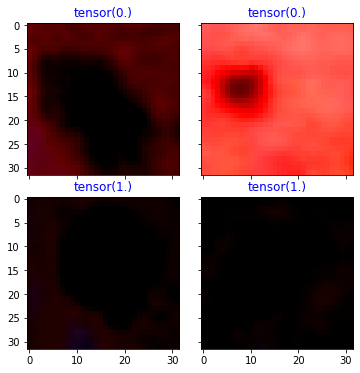

In [203]:
def _make_grid(image_path_list,label,n_row=2, n_col=2,fig_size=(6,6)):
    fig = plt.figure(figsize=fig_size)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(n_row,n_col),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     )
    print(label)
    for ax,fname,title in zip(grid, image_path_list,label):
        # Iterating over the grid returns the Axes.
        # im= plt.imread(fname)
        # file_name = fname.split('/')[-1]
        ax.imshow(fname.permute( 2, 1,0))
        ax.set_title(title,color='blue')

    plt.show()

_make_grid(img,_,n_row=2, n_col=2,fig_size=(6,6))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0., 0., 1., 1.])


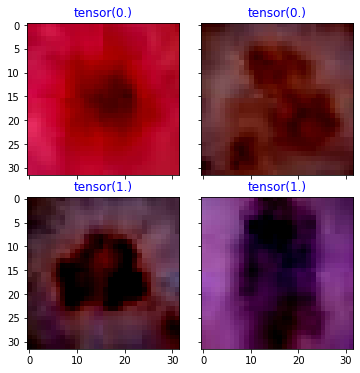

In [213]:
img,_ = next(iter(test_loader))
_make_grid(img,_,n_row=2, n_col=2,fig_size=(6,6))

In [216]:
class UnlabelledMelanomaDataset(Dataset):
# dir_path, transform=None
    def __init__(self, 
                 file_names: list, 
                 transforms = None):
      
        super().__init__()

        self.image_ids = file_names
        self.image_dir = os.path.commonprefix(file_names)
        # self.labels = [os.path.basename(os.path.join(i)).split('.')[0].split('_')[1] 
        #                for i in file_names]

        self.transform = transforms
        # self.train = train


    def __getitem__(self, index: int):
        image_id = self.image_ids[index]

        image = cv2.imread(f'{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)#.astype(np.float32)
        # image /= 255.0
        # image = torch.tensor(image)
        
        PIL_image = Image.fromarray(image)
        # if self.train:
        #   target = torch.tensor(np.float32(self.labels[index]))
          
        if self.transform:
            image = self.transform(PIL_image)
        return image

    def __len__(self) -> int:
        return len(self.image_ids)

In [217]:
unlabelled_dataset = UnlabelledMelanomaDataset(unlabelled_list,
                                  
                          
                                   transforms = test_transformation,

                                   )

In [218]:
unlabelled_loader = torch.utils.data.DataLoader(unlabelled_dataset,
                                               batch_size=4,
                                               pin_memory=True,
                                               num_workers=6,
                                               shuffle=True
                                               )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['NA', 'NA', 'NA', 'NA']


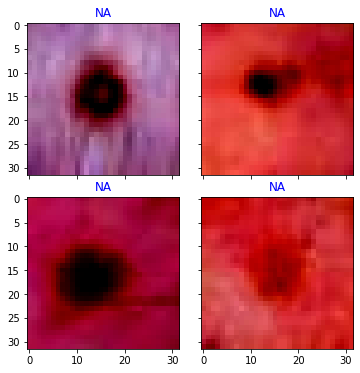

In [220]:
img = next(iter(unlabelled_loader))
_make_grid(img,['NA','NA','NA','NA'],n_row=2, n_col=2,fig_size=(6,6))